In [1]:
from animate import anim 
import numpy as np
import torch 
from model import PINNs
from deepxrte.geometry import Rectangle
import pandas as pd



In [2]:
model = PINNs()
checkpoint = torch.load('4_turb_first/epoch800'+'/model_weights.pth', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [3]:
# Avec Z et le choix des points avec une certaine proba
from deepxrte.geometry import Rectangle
import torch
import torch.nn as nn
import torch.optim as optim
from model import PINNs
from utils import read_csv, write_csv
from train import train
from pathlib import Path
import time
import pandas as pd
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

time_start = time.time()

############# LES VARIABLES ################

folder_result = "3_uniform"  # le nom du dossier de résultat

random_seed_train = None
# la seed de test, toujours garder la même pour pouvoir comparer
random_seed_test = 2002


##### Le modèle de résolution de l'équation de la chaleur
nb_itt = 2800  # le nb d'epoch
save_rate = 50
poids = [1, 1]  # les poids pour la loss

batch_size = 5000  # la taille d'un batch
# batch_size_pde = 1  # le nb de points pour la pde ### Pour l'instant on prend la même taille

n_pde = 1000000

n_data_test = 5000
n_pde_test = 5000

Re = 100

lr = 1e-3

gamma_scheduler = 0.999


##### Le code ###############################
###############################################

# La data
# On adimensionne la data
df = pd.read_csv("data.csv")
df_modified = df[
    (df["Points:0"] >= 0.015)
    & (df["Points:0"] <= 0.2)
    & (df["Points:1"] >= -0.1)
    & (df["Points:1"] <= 0.1)
    & (df["Time"] > 4)
    & (df["Time"] < 6)
]
# Uniquement la fin de la turbulence

x_full, y_full, t_full = (
    np.array(df_modified["Points:0"]),
    np.array(df_modified["Points:1"]),
    np.array(df_modified["Time"]),
)
u_full, v_full, p_full = (
    np.array(df_modified["Velocity:0"]),
    np.array(df_modified["Velocity:1"]),
    np.array(df_modified["Pressure"]),
)

x_norm_full = (x_full - x_full.mean()) / x_full.std()
y_norm_full = (y_full - y_full.mean()) / y_full.std()
t_norm_full = (t_full - t_full.mean()) / t_full.std()
p_norm_full = (p_full - p_full.mean()) / p_full.std()
u_norm_full = (u_full - u_full.mean()) / u_full.std()
v_norm_full = (v_full - v_full.mean()) / v_full.std()


X_full = np.array([x_norm_full, y_norm_full, t_norm_full], dtype=np.float32).T
U_full = np.array([u_norm_full, v_norm_full, p_norm_full], dtype=np.float32).T


cpu


In [4]:
X_pred = torch.tensor(X_full, dtype=torch.float32)

In [5]:
U_pred = model(X_pred)

In [6]:
x_norm_pred, y_norm_pred, t_norm_pred = X_pred.detach().numpy()[:,0], X_pred.detach().numpy()[:,1], X_pred.detach().numpy()[:,2]
u_norm_pred, v_norm_pred, p_norm_pred = U_pred.detach().numpy()[:,0], U_pred.detach().numpy()[:,1], U_pred.detach().numpy()[:,2]

In [7]:
x_pred = x_norm_pred*x_full.std() + x_full.mean()
y_pred = y_norm_pred*y_full.std() + y_full.mean()
t_pred = t_norm_pred*t_full.std() + t_full.mean()
u_pred = u_norm_pred*u_full.std() + u_full.mean()
v_pred = v_norm_pred*v_full.std() + v_full.mean()
p_pred = p_norm_pred*p_full.std() + p_full.mean()

In [8]:
norme_vitesse = np.sqrt(u_pred**2 + v_pred**2)

In [9]:
# import matplotlib.pyplot as plt
# import numpy as np
# from matplotlib.animation import FuncAnimation


# # Pour plot

# def plot_flow(x,y,t,norme_vitesse,frame) :   
#     plt.clf()
#     time = list(set(t))
#     time.sort()
#     indices = np.where(t == time[frame])
#     plt.gca().set_aspect('equal', adjustable='box')
#     plt.tripcolor(x[indices], y[indices], norme_vitesse[indices], shading='gouraud', cmap='coolwarm', vmin=0, vmax=1.3)
#     plt.colorbar(label='Norme vitesse')
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.title(f'Carte de chaleur à t_ad={time[frame]:.2f}')
    
# def anim(name_file, x, y, t, norme_vitesse):
#     fig = plt.figure()
#     def animate(frame):
#         plot_flow(x,y,t,norme_vitesse, frame)
#         print(frame)
#         return fig,
#     ani = FuncAnimation(fig, animate, frames=np.arange(0, len(set(t))))#, repeat=False)
#     ani.save(name_file, writer='pillow', fps=7)

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
0


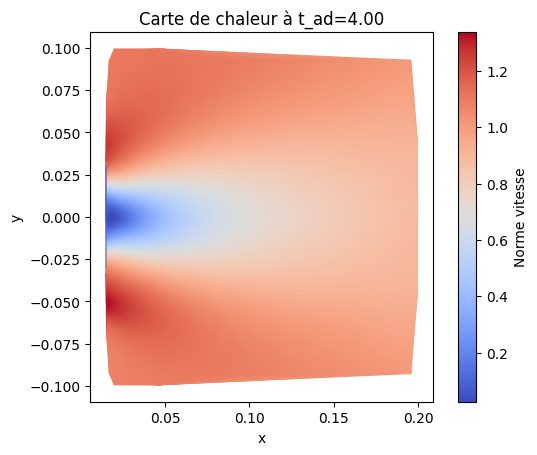

In [10]:
with torch.no_grad():
    anim('supervised.gif', x_pred, y_pred, t_pred, norme_vitesse)